In [1]:
import cv2
import iris
import matplotlib.pyplot as plt
import numpy as np

from iris.orchestration.environment import Environment
from iris.orchestration.error_managers import store_error_manager
from iris.callbacks.pipeline_trace import NodeResultsWriter, PipelineCallTraceStorage, PipelineCallTraceStorageError
from iris.orchestration.output_builders import build_orb_output, build_simple_debugging_output, build_simple_orb_output

/mnt/pool1/sharehome/usman/.conda/envs/iris_dev/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import iris

print(iris.__version__)

1.1.1


In [3]:
import yaml
config_path = 'pipeline_sam.yaml'

config = yaml.safe_load(open(config_path, 'r'))

In [4]:
iris_pipeline = iris.IRISPipeline(config=config,
                                  env = Environment(
            pipeline_output_builder=build_simple_debugging_output,
            error_manager=store_error_manager,
            call_trace_initialiser=PipelineCallTraceStorage.initialise,
        ))

In [8]:
def get_bounding_box(ground_truth_map, add_noise=True):
    """The function below defines how to get a bounding box prompt based on the ground truth segmentation.
    This was taken from [here](https://github.com/bowang-lab/MedSAM/blob/66cf4799a9ab9a8e08428a5087e73fc21b2b61cd/train.py#L29)."""
    # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    if len(y_indices) == 0 or len(x_indices) == 0:
        return np.array([0, 0, 0, 0])
    
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    if add_noise:
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return np.array(bbox)

def masks_to_bboxes(masks, num_classes):
    """
    A function to convert a mask to bounding boxes used as input to SAM model
    """
    masks_list = []
    for i in range(num_classes):
        mask = (masks == i+1).astype(np.uint8) * 255
        masks_list.append(mask)
    
    bboxes = []
    for gt_mask in masks_list:
        bbox = get_bounding_box(gt_mask)
        bboxes.append(bbox)
    bboxes = np.array(bboxes)
    
    return bboxes

In [9]:
img_pixels = cv2.imread("data/images/S1001L01.jpg", cv2.IMREAD_GRAYSCALE)
masks = cv2.imread("data/masks/S1001L01.png", cv2.IMREAD_GRAYSCALE)

In [11]:
bboxes = masks_to_bboxes(masks, num_classes=5)
print(bboxes)

[[ 32  15 275 204]
 [ 81  53 228 173]
 [  0  23 320 200]
 [  0   0 320 118]
 [  1 166 320 273]]


In [12]:
output = iris_pipeline(img_data=img_pixels, eye_side="left", bboxes=bboxes)

In [13]:
output.keys()

dict_keys(['iris_template', 'metadata', 'segmentation_map', 'segmentation_binarization', 'extrapolated_polygons', 'normalized_iris', 'iris_response', 'error'])

## print out meta data (quality measures)

In [14]:
output['metadata']

{'iris_version': '1.1.1',
 'image_size': (320, 280),
 'eye_side': 'left',
 'eye_centers': {'iris_center': (155.3745318944762, 116.55921328531564),
  'pupil_center': (155.28827836169248, 115.31739130709379)},
 'pupil_to_iris_property': {'pupil_to_iris_diameter_ratio': 0.4953392270014333,
  'pupil_to_iris_center_dist_ratio': 0.010848269442442942},
 'offgaze_score': 0.0011907880177221023,
 'eye_orientation': -0.03931405650312669,
 'occlusion90': 0.7000200454363223,
 'occlusion30': 0.9886237513873474,
 'iris_bbox': {'x_min': 46.89311218261719,
  'y_min': 3.313579559326172,
  'x_max': 269.0123596191406,
  'y_max': 228.22999572753906}}

# visualize segmentation results

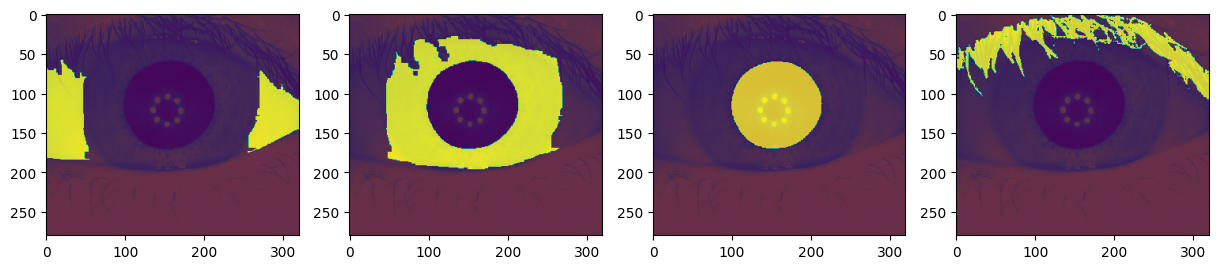

In [15]:
fig, ax = plt.subplots(1, 4, figsize=(15, 20))
for i in range(4):
    ax[i].imshow(img_pixels)
    ax[i].imshow(output['segmentation_map']['predictions'][:,:,i], alpha=0.8)

# visualize normalization results

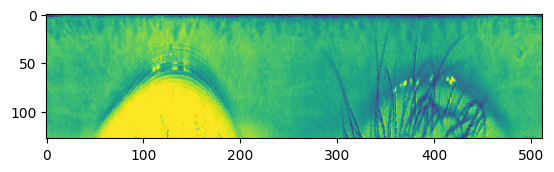

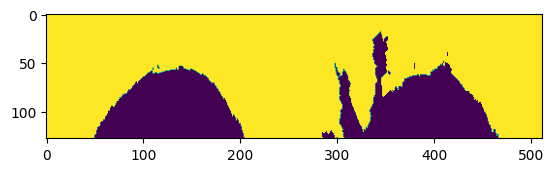

In [16]:
plt.imshow(output['normalized_iris']['normalized_image'])
plt.show()
plt.imshow(output['normalized_iris']['normalized_mask'])

## visualize iris response results

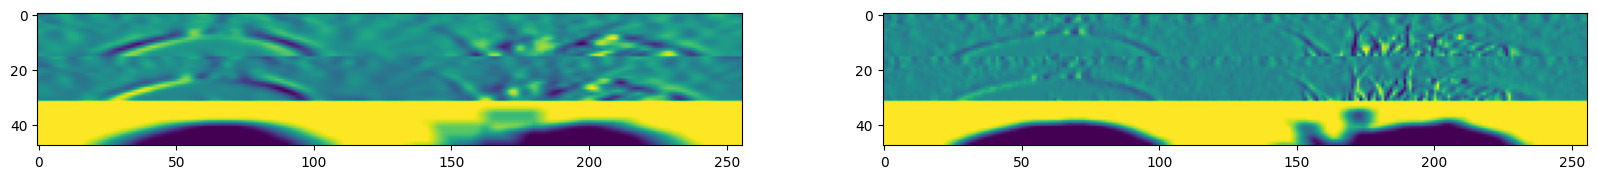

In [17]:
def normalize_array(arr):
    norm_arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
    return norm_arr

fig, ax = plt.subplots(1, 2, figsize=(20, 40))
for i in range(2):
    ax[i].imshow(np.vstack((normalize_array(output['iris_response']['iris_responses'][i].real), normalize_array(output['iris_response']['iris_responses'][i].imag), normalize_array(output['iris_response']['mask_responses'][i]))))

## visualize iris codes results

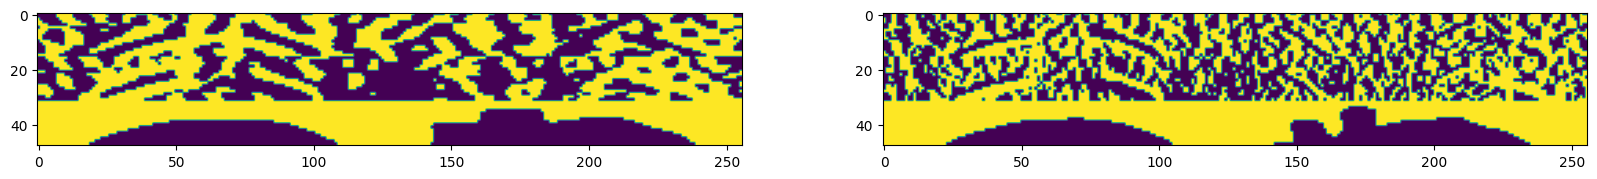

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20, 40))
for i in range(2):
    ax[i].imshow(np.vstack((output['iris_template'].iris_codes[i][:,:,0], output['iris_template'].iris_codes[i][:,:,1], output['iris_template'].mask_codes[i][:,:,0])))


## visualize gabor filters

In [19]:
from iris.nodes.iris_response.image_filters.gabor_filters import GaborFilter
filters = [
            GaborFilter(
                kernel_size=(41, 21),
                sigma_phi=7,
                sigma_rho=6.13,
                theta_degrees=90.0,
                lambda_phi=28,
                dc_correction=True,
                to_fixpoints=True,
            ),
            GaborFilter(
                kernel_size=(17, 21),
                sigma_phi=2,
                sigma_rho=5.86,
                theta_degrees=90.0,
                lambda_phi=8,
                dc_correction=True,
                to_fixpoints=True,
            ),
]

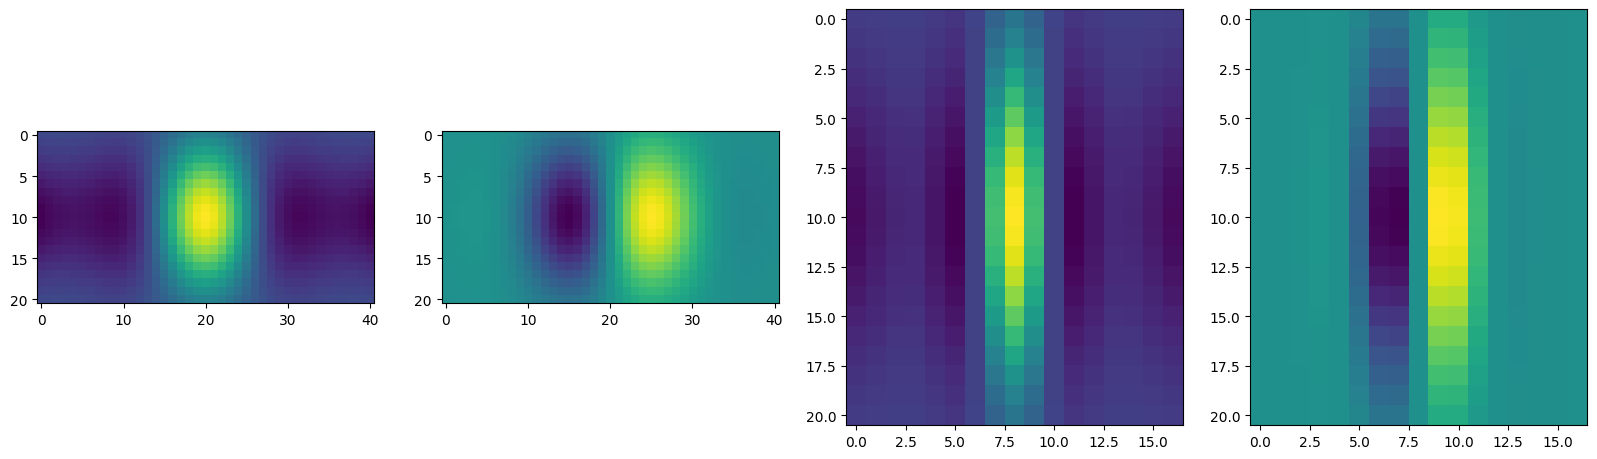

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(20, 60))
for i in range(2):
    kernel_values = filters[i].compute_kernel_values()
    ax[i*2].imshow(kernel_values.real)
    ax[i*2 + 1].imshow(kernel_values.imag)

## use iris.visualization

In [21]:
iris_visualizer = iris.visualisation.IRISVisualizer()

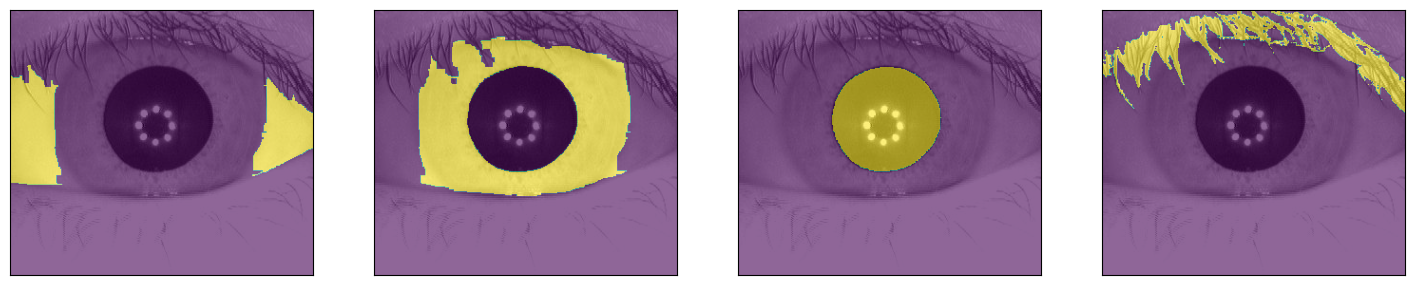

In [23]:
canvas = iris_visualizer.plot_segmentation_map(
    ir_image=iris.IRImage(img_data=img_pixels, eye_side="right", bboxes=bboxes),
    segmap=iris_pipeline.call_trace['segmentation'],
)
plt.show()

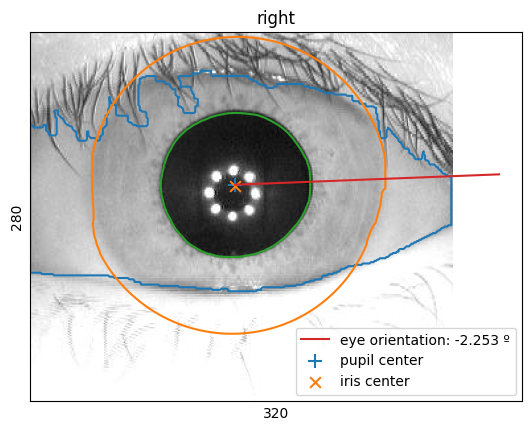

In [25]:
canvas = iris_visualizer.plot_all_geometry(
    ir_image=iris.IRImage(img_data=img_pixels, eye_side="right", bboxes=bboxes),
    geometry_polygons=iris_pipeline.call_trace['geometry_estimation'],
    eye_orientation=iris_pipeline.call_trace['eye_orientation'],
    eye_center=iris_pipeline.call_trace['eye_center_estimation'],
)
plt.show()

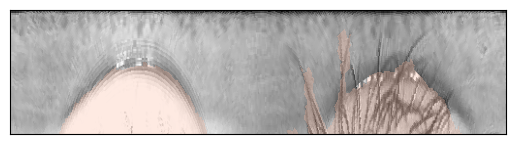

In [26]:
canvas = iris_visualizer.plot_normalized_iris(
    normalized_iris=iris_pipeline.call_trace['normalization'],
)
plt.show()

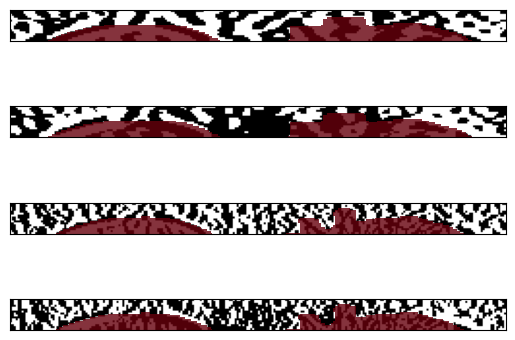

In [27]:
canvas = iris_visualizer.plot_iris_template(
    iris_template=iris_pipeline.call_trace['encoder'],
)
plt.show()